In [ ]:
!mkdir data
!wget https://github.com/yk4r2/AAA/blob/main/Experiments/homeworks/HW3/data/user_amount_var_reduction.tar.xz?raw=true -O data/user_amount_var_reduction.tar.xz

mkdir: cannot create directory ‘data’: File exists
--2021-04-15 21:46:15--  https://github.com/yk4r2/AAA/blob/main/Experiments/homeworks/HW3/data/user_amount_var_reduction.tar.xz?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/yk4r2/AAA/raw/main/Experiments/homeworks/HW3/data/user_amount_var_reduction.tar.xz [following]
--2021-04-15 21:46:16--  https://github.com/yk4r2/AAA/raw/main/Experiments/homeworks/HW3/data/user_amount_var_reduction.tar.xz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/yk4r2/AAA/main/Experiments/homeworks/HW3/data/user_amount_var_reduction.tar.xz [following]
--2021-04-15 21:46:16--  https://raw.githubusercontent.com/yk4r2/AAA/main/Experiments/homeworks/HW3/data/user_amount_var_reduction.tar.xz
Resolving raw.githubu

In [ ]:
!tar -xf data/user_amount_var_reduction.tar.xz

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
from datetime import timedelta
import random
from statsmodels.stats.power import tt_ind_solve_power
from math import ceil

def date_converter(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

### Задание 3
**Срок сдачи: 04 апреля 21:00**

**Финальный срок сдачи с понижением балов до 50%: 09 апреля 21:00**

В этом задание вы будете работать с выручкой - метрикой с достаточно высокой дисперсией и соответственно низкой чувствительностью к изменениям.

Вам предстоит разработать подход по повышению чувствительности этой метрики.
От успеха данной инициативы зависит то, как быстро мы сможем проверять продуктовые гипотезы.

#### Для планирования эксперимента изучите данные и метрики (2 балла):

- Загрузите файл и изучите данные;
- Постройте графики плотности распределения для этих метрик и сделайте выводы о характере распределений: тип, наличие выбросов, насколько сильный разброс.
- Изучите основные статистики метрики: среднее, стандартное отклонение;
- Изучите то, насколько эти статистики подвержены сезональности;
- Изучите то, как эти статистики изменяются внутри срезов: user_segment, region, category

#### Предскажите минимально детектируемый эффект (MDE) (2 балла):

- Для размеров тестовых групп 10%, 25%, 50% и длительностей 30, 60, 90 дней предскажите минимально детектируемый эффект;


#### CUPED (6 баллов)
Разработайте подход по снижению дисперсии на основе методики CUPED:

- Рассчитайте CUPED метрику на основе данных за периода в 30 дней перед предполагаемым периодом сбора основной выборки и опишите как изменился MDE для выборок 50/50%, собранных за 30 дней (2 балла). 
- Проверьте насколько данный подход подвержен сезональности. Как меняется MDE, если применять данный подход в разные периоды (2 балла). 
- Оптимизируйте подход варьируя количество дней до теста, которые вы будете для расчёта CUPED метрики. Какое максимальное снижение MDE вы смогли достичь (2 балла).



#### * Стратификация (4 балла) (задание для получения дополнительных баллов)
Разработайте подход по снижению дисперсии на основе методики стратификации выборок:

- Стратифицируйте выборки внутри срезов user_segment, region, category
- Рассчитайте стратифицированные среднее,стандартное отклонение для этих выборок и MDE для теста 50/50% длительностью 30 дней.
- В каких срезах достигается наибольшее снижение MDE?


#### Описание данныx

event_date - дата 

user_id - идентификатор пользователя

user_segment - тип продукта

region - регион

category - категория авито

revenue_amount - сумма покупок


### Загрузка датасета + первый взгляд

In [ ]:
df = pd.read_csv('user_amount_var_reduction.csv')
df['event_date'] = df.event_date.apply(date_converter)

In [ ]:
df.sample(5)

,event_date,user_id,user_segment,category,region,revenue_amount
4446276,2019-09-30,1650301927494156673,4626944681007198896,3619272498251215842,4698304106702583730,14
6622382,2019-11-05,3833610671196796266,2376074197230840906,1472231361867825698,8020568142410910978,133
4465935,2019-09-17,2666147064822167482,2376074197230840906,57514010642945023,5780543780372929118,974
417757,2019-06-28,6977231699988281671,853431062533847667,6742557862815872936,3855810523611026650,1091
8285442,2019-10-21,5977246750949925652,4626944681007198896,4394253463123676325,5147573593228829405,35


In [ ]:
df.shape

(8625842, 6)

Жесть он тяжёлый. Будем пока работать с маленькой версией.

In [ ]:
light_df = df[['event_date', 'user_id','revenue_amount']]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


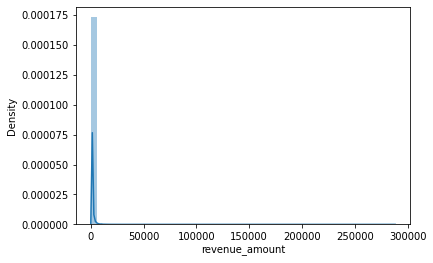

In [ ]:
sns.distplot(light_df['revenue_amount'])

Давайте посмотрим, как часто у нас выходила выручка больше 2.000?

In [ ]:
len(light_df[light_df['revenue_amount'] > 2000]) / len(light_df)

0.02548087479459976

Около 2.5%. Давайте отрежем, чтоб посмотреть поближе на характер распределения.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


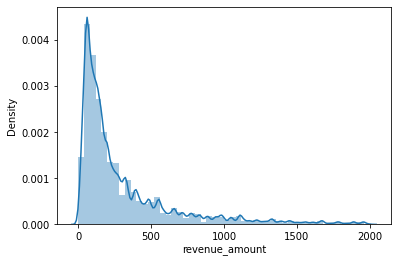

In [ ]:
sns.distplot(light_df[light_df['revenue_amount'] < 2000].revenue_amount)

Тип распределения: хвостатое, мегапохоже на гамму.

Наличие выбросов: есть выбросы, из которых сформирован тяжёлый хвост. Дальше 2000 около 2.5% транзакций, дальше 10000 около 0.1%.

Разброс: сильный, учитывая околонулевую медиану и наличие транзакций стоимостью 300.000

In [ ]:
main_metric = light_df['revenue_amount']
print(f'mean = {main_metric.mean()}, median = {main_metric.median()}, mode = {main_metric.mode().values[0]}')

mean = 400.9046571917269, median = 167.0, mode = 90


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


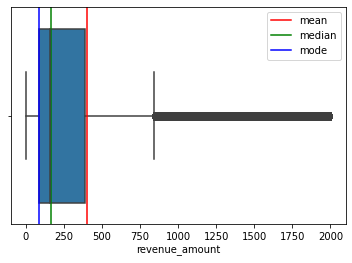

In [ ]:
ax = sns.boxplot(main_metric[main_metric < 2000])
ax.axvline(main_metric.mean(), color='r', label='mean')
ax.axvline(main_metric.median(), color='g', label='median')
ax.axvline(main_metric.mode().values[0], color='b', label='mode')
ax.legend()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


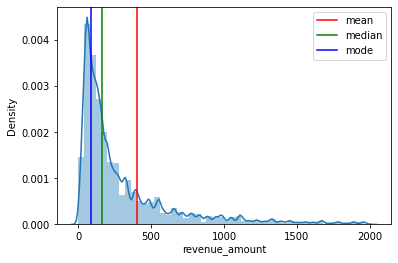

In [ ]:
ax = sns.distplot(main_metric[main_metric < 2000])
ax.axvline(main_metric.mean(), color='r', label='mean')
ax.axvline(main_metric.median(), color='g', label='median')
ax.axvline(main_metric.mode().values[0], color='b', label='mode')
ax.legend()

Изучим сезональность: сравним начало датасета и конец

In [ ]:
light_df['event_date'].min(), light_df['event_date'].max()

(Timestamp('2019-06-18 00:00:00'), Timestamp('2019-12-09 00:00:00'))

In [ ]:
first_plotter = light_df[(light_df['event_date'] < light_df['event_date'].min() + timedelta(days=30)) & (main_metric[main_metric < 2000])]['revenue_amount']
second_plotter = light_df[(light_df['event_date'] > light_df['event_date'].max() - timedelta(days=30)) & (main_metric[main_metric < 2000])]['revenue_amount']

In [ ]:
season_1 = light_df[light_df['event_date'] < light_df['event_date'].min() + timedelta(days=30)].revenue_amount
season_2 = light_df[light_df['event_date'] > light_df['event_date'].max() - timedelta(days=30)].revenue_amount
print(f'Season_1: mean = {season_1.mean()}, median = {season_1.median()}, mode = {season_1.mode().values[0]}')
print(f'Season_2: mean = {season_2.mean()}, median = {season_2.median()}, mode = {season_2.mode().values[0]}')

Season_1: mean = 412.1531697184182, median = 184.0, mode = 69
Season_2: mean = 394.2505709713255, median = 167.0, mode = 90


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


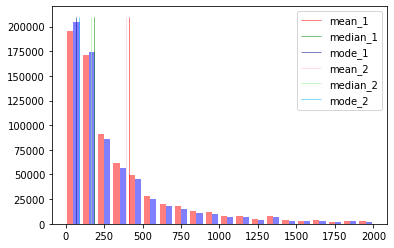

In [ ]:
plt.hist([first_plotter, second_plotter], color=['r','b'], alpha=0.5, bins=20)

plt.vlines(season_1.mean(), ymin=0, ymax=210000, color='r', label='mean_1', linewidth=0.5)
plt.vlines(season_1.median(), ymin=0, ymax=210000, color='g', label='median_1', linewidth=0.5)
plt.vlines(season_1.mode().values[0], ymin=0, ymax=210000, color='darkblue', label='mode_1', linewidth=0.5)

plt.vlines(season_2.mean(), ymin=0, ymax=210000, color='pink', label='mean_2', linewidth=0.5)
plt.vlines(season_2.median(), ymin=0, ymax=210000, color='lightgreen', label='median_2', linewidth=0.5)
plt.vlines(season_2.mode().values[0], ymin=0, ymax=210000, color='deepskyblue', label='mode_2', linewidth=0.5)
plt.legend()
plt.show()

Сезональность как будто бы есть, но не сильно большая.

Посмотрим поближе: сгруппируем по месяцам и посчитаем основные статистики для каждого месяца.

In [ ]:
df[['revenue_amount', 'event_date']].resample('M', on='event_date').agg({'revenue_amount': ["count", "mean", "median", pd.Series.mode]})

revenue_amount                        
                    count        mean median mode
event_date                                       
2019-06-30         605386  402.789843    176   90
2019-07-31        1499448  418.157773    188   90
2019-08-31        1501908  411.441507    175   69
2019-09-30        1556095  394.490285    167   69
2019-10-31        1726563  396.922471    167   90
2019-11-30        1322401  383.554895    161   90
2019-12-31         414041  393.570639    167   69

АГА, ВОТ ОНО

Сезонность в количестве транзакций, еее

Посмотрим на другие разбиения

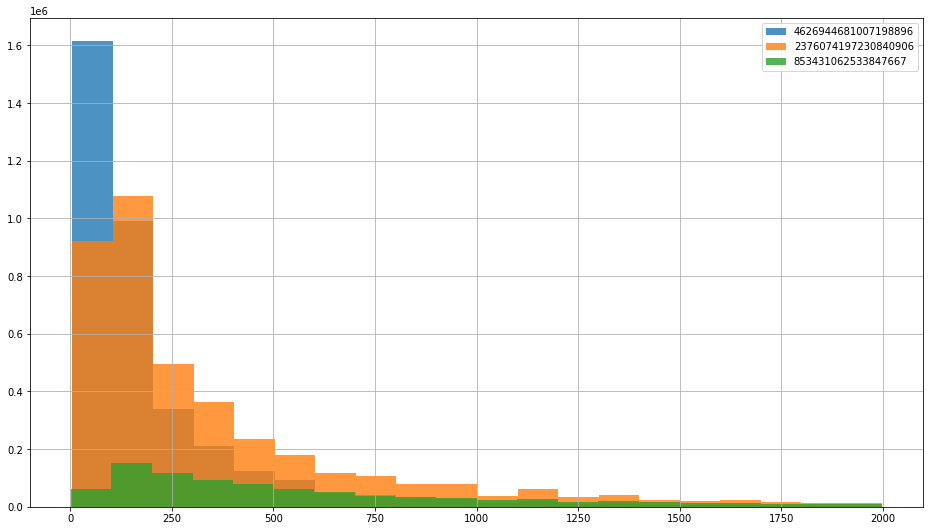

In [ ]:
plt.figure(figsize=(16, 9))
for unique_val in df['user_segment'].unique():
    df[(df.revenue_amount < 2000) & (df.user_segment == unique_val)].revenue_amount.hist(label=unique_val, alpha=0.8, bins=20)
plt.legend()
plt.show()

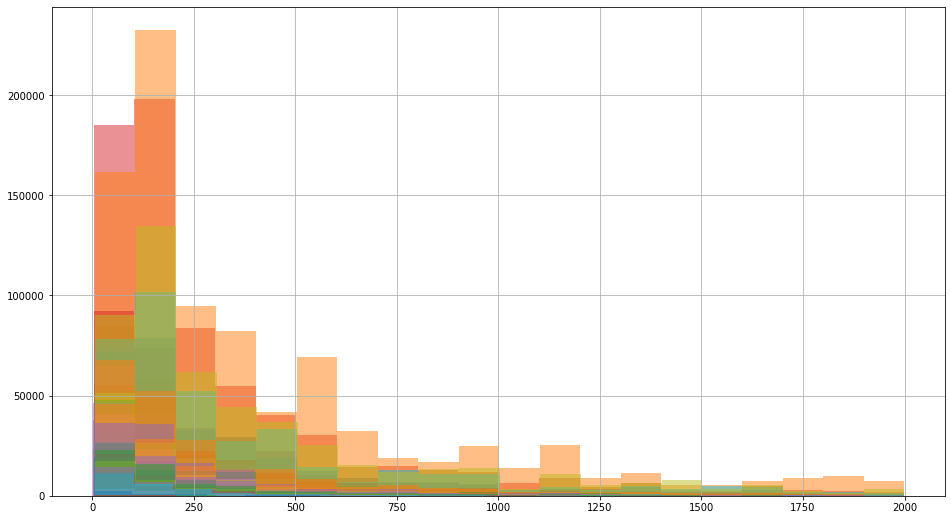

In [ ]:
plt.figure(figsize=(16, 9))
for unique_val in df['region'].unique():
    df[(df.revenue_amount < 2000) & (df.region == unique_val)].revenue_amount.hist(label=unique_val, alpha=0.5, bins=20)
plt.show()

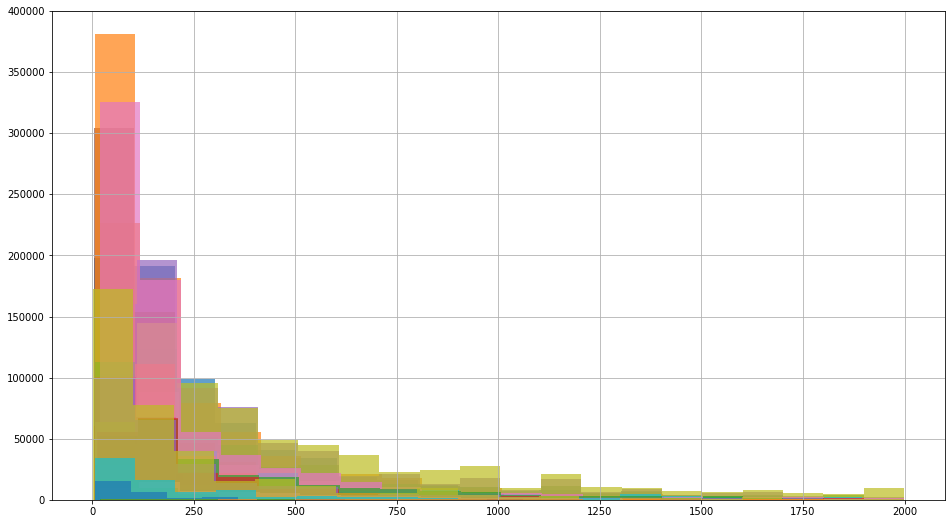

In [ ]:
plt.figure(figsize=(16, 9))
for unique_val in df['category'].unique():
    df[(df.revenue_amount < 2000) & (df.category == unique_val)].revenue_amount.hist(label=unique_val, alpha=0.7, bins=20)
plt.show()

### MDE

Мы отловили сезонность в количестве заказов, поэтому посмотрим на 2-3-4 месяцы, как на +- одинаково загруженные.

На всякий случай домножу количество дней на множитель, чтобы получить понятную картину.

In [ ]:
df[['revenue_amount', 'event_date']].resample('M', on='event_date').agg({'revenue_amount': ["count", "mean", "median", pd.Series.mode]})

revenue_amount                        
                    count        mean median mode
event_date                                       
2019-06-30         605386  402.789843    176   90
2019-07-31        1499448  418.157773    188   90
2019-08-31        1501908  411.441507    175   69
2019-09-30        1556095  394.490285    167   69
2019-10-31        1726563  396.922471    167   90
2019-11-30        1322401  383.554895    161   90
2019-12-31         414041  393.570639    167   69

Тут я пытался тупо сгруппировать по `user_id` и получал очень весёлый сайдэффект.

У меня тупо повышался нужный размер выборки вместо понижения, что было довольно весело.

Оказалось, дело в не_рандомной генерации `id`, я потратил около 2х часов на то, чтобы это понять, мда. Видно даже на этой, +- сбалансированной по количеству транзакций, выборке.

Старый код ниже

In [ ]:
def choose_date_old(data, start_date, delta, share, grouper): 
    tmp = data[(data.event_date>=start_date)&(data.event_date<=start_date+datetime.timedelta(days=delta))]
    tmp_len = len(tmp)
    print(f'df_len = {tmp_len}')
    tmp=tmp.groupby([grouper]).sum().reset_index()
    x = tmp[(tmp[grouper])%int(1/share)==1].reset_index()
    print(f'x_len = {len(x)}, {len(x) / tmp_len:.2%}, share = {share}')
    return x

In [ ]:
def mde_getter_old(data, share, grouper, metric, start_date):
    start_date = pd.to_datetime(start_date)
    days_list = list(range(30, 91, 30))
    sample_vols = []

    for days in days_list:
        #получаем необходимую подвыборку
        x1 = choose_date_old(data, start_date, days, share, grouper) 

        mean = x1[metric].mean()
        std = x1[metric].std()
        
        alpha = 0.05
        power = 0.8
        # целевой размер относительного отклоенения исходной метрики
        result_effect = 0.04 
        effect_size = (mean / std) * result_effect

        sample_vol = tt_ind_solve_power(effect_size = effect_size,
                                        alpha = alpha,
                                        power = power,
                                        nobs1 = None,
                                        ratio = 1,
                                        alternative = 'two-sided',
                                        )
        sample_vols.append(sample_vol / x1.shape[0])
    
    return metric, days_list, sample_vols, share

In [ ]:
mde_getter_old(df, share=0.5, grouper='user_id', metric='revenue_amount', start_date='2019-07-31')

df_len = 1511935
x_len = 300414, 19.87%, share = 0.5
df_len = 3047174
x_len = 478214, 15.69%, share = 0.5
df_len = 4723674
x_len = 638986, 13.53%, share = 0.5


('revenue_amount',
 [30, 60, 90],
 [1.4949031583625614, 1.3543242555992312, 1.3860609866752969],
 0.5)

Новый код:

In [ ]:
def choose_date(data, start_date, delta, share, grouper): 
    """
    Функция выбора 2 подвыборок из загруженных данных:
    data - входные данные;
    start_date - дата начала одвыборки;
    delta - длительность периода для подвыборки;
    share - доля пользователей в одной подвыборке.
    """
    tmp = data[(data.event_date >= start_date) &
               (data.event_date <= start_date + datetime.timedelta(days = delta))
               ]
    tmp_len = len(tmp)
    print(f'df_len = {tmp_len}')
    tmp['grouper_new'] = pd.util.hash_pandas_object(tmp[grouper])
    tmp = tmp.groupby(['grouper_new']).sum().reset_index()
    x = tmp[tmp['grouper_new'] % int(1 / share) == 1].reset_index()
    x.drop('grouper_new', axis=1)
    print(f'x_len = {len(x)}, {len(x) / tmp_len:.2%}, share = {share}')
    return x

In [ ]:
def mde_getter(data, share, grouper, metric, start_date):
    start_date = pd.to_datetime(start_date)
    days_list = list(range(30, 91, 30))
    sample_vols = []

    for days in days_list:
        #получаем необходимую подвыборку
        x1 = choose_date(data, start_date, days, share, grouper) 

        mean = x1[metric].mean()
        std = x1[metric].std()
        
        alpha = 0.05
        power = 0.8
        # целевой размер относительного отклоенения исходной метрики
        result_effect = 0.04 
        effect_size = (mean / std) * result_effect

        sample_vol = tt_ind_solve_power(effect_size = effect_size,
                                        alpha = alpha,
                                        power = power,
                                        nobs1 = None,
                                        ratio = 1,
                                        alternative = 'two-sided',
                                        )
        sample_vols.append(sample_vol / x1.shape[0])
    
    return metric, days_list, sample_vols, share, len(x1)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
result = []
for proportion in [.10, .25, .5]:
    result.append(mde_getter(df, share=proportion, grouper='user_id', metric='revenue_amount', start_date='2019-07-31'))

df_len = 1511935
x_len = 151377, 10.01%, share = 0.1
df_len = 3047174
x_len = 304615, 10.00%, share = 0.1
df_len = 4723674
x_len = 472559, 10.00%, share = 0.1
df_len = 1511935
x_len = 378876, 25.06%, share = 0.25
df_len = 3047174
x_len = 762406, 25.02%, share = 0.25
df_len = 4723674
x_len = 1181208, 25.01%, share = 0.25
df_len = 1511935
x_len = 755958, 50.00%, share = 0.5
df_len = 3047174
x_len = 1523204, 49.99%, share = 0.5
df_len = 4723674
x_len = 2360942, 49.98%, share = 0.5


In [ ]:
for item in result:
    metric, days_list, sample_vols, share, sample_len = item
    for day in range(len(days_list)):
        print(f'For {metric} and duration = {days_list[day]} and group size = {share} we have to enlarge our duration in {sample_vols[day]:0.3} times to have {ceil(sample_len * sample_vols[day])} observations')
    print()

For revenue_amount and duration = 30 and group size = 0.1 we have to enlarge our duration in 0.33 times to have 155735 observations
For revenue_amount and duration = 60 and group size = 0.1 we have to enlarge our duration in 0.168 times to have 79254 observations
For revenue_amount and duration = 90 and group size = 0.1 we have to enlarge our duration in 0.13 times to have 61580 observations

For revenue_amount and duration = 30 and group size = 0.25 we have to enlarge our duration in 0.128 times to have 150913 observations
For revenue_amount and duration = 60 and group size = 0.25 we have to enlarge our duration in 0.0636 times to have 75088 observations
For revenue_amount and duration = 90 and group size = 0.25 we have to enlarge our duration in 0.046 times to have 54357 observations

For revenue_amount and duration = 30 and group size = 0.5 we have to enlarge our duration in 0.0634 times to have 149712 observations
For revenue_amount and duration = 60 and group size = 0.5 we have to

Посмотрим на последние 90 дней

In [ ]:
res_last = []
for proportion in [.1, .25, .5]:
    res_last.append(mde_getter(df, share=proportion, grouper='user_id', metric='revenue_amount', start_date='2019-10-31'))

df_len = 1377729
x_len = 137832, 10.00%, share = 0.1
df_len = 1791770
x_len = 179181, 10.00%, share = 0.1
df_len = 1791770
x_len = 179181, 10.00%, share = 0.1
df_len = 1377729
x_len = 344112, 24.98%, share = 0.25
df_len = 1791770
x_len = 447245, 24.96%, share = 0.25
df_len = 1791770
x_len = 447245, 24.96%, share = 0.25
df_len = 1377729
x_len = 689158, 50.02%, share = 0.5
df_len = 1791770
x_len = 896049, 50.01%, share = 0.5
df_len = 1791770
x_len = 896049, 50.01%, share = 0.5


In [ ]:
for item in res_last:
    metric, days_list, sample_vols, share, sample_len = item
    for day in range(len(days_list)):
        print(f'For {metric} and duration = {days_list[day]} and group size = {share} we have to enlarge our duration in {sample_vols[day]:0.3} times to have total {ceil(sample_len * sample_vols[day])} observations')
    print()

For revenue_amount and duration = 30 and group size = 0.1 we have to enlarge our duration in 0.517 times to have total 92584 observations
For revenue_amount and duration = 60 and group size = 0.1 we have to enlarge our duration in 0.36 times to have total 64554 observations
For revenue_amount and duration = 90 and group size = 0.1 we have to enlarge our duration in 0.36 times to have total 64554 observations

For revenue_amount and duration = 30 and group size = 0.25 we have to enlarge our duration in 0.227 times to have total 101575 observations
For revenue_amount and duration = 60 and group size = 0.25 we have to enlarge our duration in 0.16 times to have total 71679 observations
For revenue_amount and duration = 90 and group size = 0.25 we have to enlarge our duration in 0.16 times to have total 71679 observations

For revenue_amount and duration = 30 and group size = 0.5 we have to enlarge our duration in 0.103 times to have total 91989 observations
For revenue_amount and duration 

### CUPED

Предположим, мы не хотим тревожить много людей, итого мы хотим максимум 100.000 наблюдений.

Попробуем подобрать разбиение так, чтобы 25% от него было 100.000

In [ ]:
df[['revenue_amount', 'event_date']].resample('W', on='event_date').agg({'revenue_amount': ["count", "mean", "median", pd.Series.mode]}).tail()

revenue_amount                        
                    count        mean median mode
event_date                                       
2019-11-17         284285  361.128839    160   90
2019-11-24         354573  404.672970    167   90
2019-12-01         353160  408.654848    168   69
2019-12-08         374133  399.611285    167   90
2019-12-15              1   91.000000     91   91

Выходит, что мы можем взять чуть больше чем последнюю неделю. Но тут может вмешаться недельная сезонность, а нам лучше пере-, чем недо-, поэтому или возьмём две недели c долей в 25%, или раскатим недельный эксперимент на всех пользователей, взяв долю в 50%.

В контексте месяца:

In [ ]:
df[['revenue_amount', 'event_date']].resample('M', on='event_date').agg({'revenue_amount': ["count", "mean", "median", pd.Series.mode]})

revenue_amount                        
                    count        mean median mode
event_date                                       
2019-06-30         605386  402.789843    176   90
2019-07-31        1499448  418.157773    188   90
2019-08-31        1501908  411.441507    175   69
2019-09-30        1556095  394.490285    167   69
2019-10-31        1726563  396.922471    167   90
2019-11-30        1322401  383.554895    161   90
2019-12-31         414041  393.570639    167   69

Вообще т.к. написано посчитать CUPED за месяц до предполагаемого эксперимента, получается, что мы можем взять 11 месяц и посчитать на нём дату для 12 месяца. Но тогда непонятно, какой размер брать, ибо 12 месяц имеет сильную просадку по продажам, поэтому чтобы уж совсем наверняка давайте возьмём для эксперимента 25% + 25% человеков.

Вот я всё это тут размышлял, а оказалось, что в задании надо считать для выборок 50/50

In [ ]:
pre_dates_df = df[(df['event_date'] >= '2019-11-01') & (df['event_date'] <= '2019-11-30')]
test_dates_df = df[(df['event_date'] >= '2019-12-01') & (df['event_date'] <= '2019-12-31')]

In [ ]:
pre_dates_df.sample(5)

,event_date,user_id,user_segment,category,region,revenue_amount
6406952,2019-11-11,1186395904347864395,4626944681007198896,3429514168013826643,1481836092404435976,140
6903055,2019-11-15,5052312978663615918,4626944681007198896,3619272498251215842,4848067518890897757,42
7631668,2019-11-26,7941113724559154488,2376074197230840906,3187769798308634693,2510779536173805371,119
6710694,2019-11-04,8415135210997402793,4626944681007198896,6549025562984299367,4607638209436083223,139
6773635,2019-11-16,8655600010083368835,2376074197230840906,7204754148424990691,7126065072605124185,636


In [ ]:
pre_metric = pre_dates_df[['user_id', 'revenue_amount']].groupby('user_id').sum()
pre_metric = pre_metric.rename(columns={'revenue_amount': 'pre_revenue'})

test_dates_df = test_dates_df.merge(pre_metric, left_on='user_id', right_index=True)

In [ ]:
test_dates_df.sample(5)

,event_date,user_id,user_segment,category,region,revenue_amount,pre_revenue
8069021,2019-12-08,3970618452449600829,4626944681007198896,91460430793700892,3855810523611026650,420,1498
7728112,2019-12-06,3992953725131866136,4626944681007198896,4394253463123676325,4626262784213375628,294,20104
8119828,2019-12-06,8919840746292678749,2376074197230840906,3187769798308634693,4459452014453832958,546,1753
7370014,2019-12-03,125971863768520611,2376074197230840906,3187769798308634693,8020568142410910978,328,4720
8097138,2019-12-08,8562395426927041956,2376074197230840906,7204754148424990691,6681910460932232567,176,377


In [ ]:
test_dates_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289042 entries, 7106137 to 8625839
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_date      289042 non-null  datetime64[ns]
 1   user_id         289042 non-null  int64         
 2   user_segment    289042 non-null  int64         
 3   category        289042 non-null  int64         
 4   region          289042 non-null  int64         
 5   revenue_amount  289042 non-null  int64         
 6   pre_revenue     289042 non-null  int64         
dtypes: datetime64[ns](1), int64(6)
memory usage: 17.6 MB


Нет нулевых значений, значит, новых юзеров не завезли. Прекрасно.

In [ ]:
test_dates_df['pre_mean'] = test_dates_df['pre_revenue'].mean()
theta = np.cov(test_dates_df.revenue_amount, test_dates_df.pre_revenue, ddof=1)[1, 0] / np.var(test_dates_df.pre_revenue, ddof=1)
corr = np.corrcoef([test_dates_df.revenue_amount, test_dates_df.pre_revenue])[1, 0]
test_dates_df['cuped_revenue'] = test_dates_df.revenue_amount - theta * (test_dates_df.pre_revenue - test_dates_df.pre_mean)

In [ ]:
test_dates_df.sample(5)

,event_date,user_id,user_segment,category,region,revenue_amount,pre_revenue,pre_mean,cuped_revenue
7662225,2019-12-01,4781097317267115885,853431062533847667,174490086998335078,1481836092404435976,489,9460,10840.868818,497.986793
7897869,2019-12-04,2530503815783278081,2376074197230840906,7948270325129383019,1116465816370945844,230,230,10840.868818,299.056295
8141454,2019-12-08,4106415494355091105,4626944681007198896,4394253463123676325,1497553293127360034,35,35,10840.868818,105.325369
7853295,2019-12-07,2177058881600963757,4626944681007198896,6864443610550051939,8020568142410910978,28,301,10840.868818,96.594222
7829013,2019-12-03,1200511143474915996,2376074197230840906,5983323600580891431,3413200001141702850,587,55,10840.868818,657.195207


In [ ]:
test_dates_df.drop(['pre_revenue', 'pre_mean'], axis=1, inplace=True)

In [ ]:
test_dates_df.describe()

,user_id,user_segment,category,region,revenue_amount,cuped_revenue
count,2.890420e+05,2.890420e+05,2.890420e+05,2.890420e+05,289042.000000,289042.000000
mean,4.603744e+18,2.822207e+18,3.979829e+18,4.128462e+18,454.355104,454.355104
std,2.670076e+18,1.318240e+18,2.751556e+18,2.495269e+18,1073.386346,1024.766263
min,3.923981e+13,8.534311e+17,5.751401e+16,6.847539e+16,6.000000,-8369.290216
25%,2.281932e+18,2.376074e+18,1.472231e+18,1.481836e+18,98.000000,149.216090
50%,4.610470e+18,2.376074e+18,3.429514e+18,3.855811e+18,195.000000,235.175020
75%,6.917290e+18,4.626945e+18,6.549026e+18,5.780544e+18,470.000000,481.372505
max,9.223367e+18,4.626945e+18,7.948270e+18,9.198009e+18,113469.000000,110115.780298


In [ ]:
def mde_30_getter(data, share, grouper, metric, start_date):
    start_date = pd.to_datetime(start_date)
    sample_vols = []
    
    #получаем необходимую подвыборку
    x1 = choose_date(data, start_date, 30, share, grouper) 

    mean = x1[metric].mean()
    std = x1[metric].std()
    
    alpha = 0.05
    power = 0.8
    # целевой размер относительного отклоенения исходной метрики
    result_effect = 0.04 
    effect_size = (mean / std) * result_effect

    sample_vol = tt_ind_solve_power(effect_size = effect_size,
                                    alpha = alpha,
                                    power = power,
                                    nobs1 = None,
                                    ratio = 1,
                                    alternative = 'two-sided',
                                    )

    return metric, 30, sample_vol / x1.shape[0], share

In [ ]:
mde_30_getter(test_dates_df, share=0.5, grouper='user_id', metric='revenue_amount', start_date='2019-12-01')

df_len = 289042
x_len = 144395, 49.96%, share = 0.5


('revenue_amount', 30, 0.35271210445593626, 0.5)

In [ ]:
mde_30_getter(test_dates_df, share=0.5, grouper='user_id', metric='cuped_revenue', start_date='2019-12-01')

df_len = 289042
x_len = 144395, 49.96%, share = 0.5


('cuped_revenue', 30, 0.3235409573174574, 0.5)

In [236]:
def revenue_mde_getter(df):
    min_date = df['event_date'].min()
    max_date = df['event_date'].max()
    pers = df['event_date'].dt.month.unique()
    idx = pd.date_range(min_date + timedelta(days=20), end=max_date - timedelta(days=61), periods = len(pers) - 3)
    mdes = []
    cuped_mdes = []
    
    for month in idx: 
        pre_dates_df = df[(df['event_date'] >= month) & (df['event_date'] <= month + timedelta(days=30))]
        test_dates_df = df[(df['event_date'] > month + timedelta(days=31)) & (df['event_date'] <= month + timedelta(days=61))]
    
        pre_metric = pre_dates_df[['user_id', 'revenue_amount']].groupby('user_id').sum()
        pre_metric = pre_metric.rename(columns={'revenue_amount': 'pre_revenue'})

        test_dates_df = test_dates_df.merge(pre_metric, left_on='user_id', right_index=True)

        test_dates_df['pre_mean'] = test_dates_df['pre_revenue'].mean()
        theta = np.cov(test_dates_df.revenue_amount, test_dates_df.pre_revenue, ddof=1)[1, 0] / np.var(test_dates_df.pre_revenue, ddof=1)
        corr = np.corrcoef([test_dates_df.revenue_amount, test_dates_df.pre_revenue])[1, 0]
        test_dates_df['cuped_revenue'] = test_dates_df.revenue_amount - theta * (test_dates_df.pre_revenue - test_dates_df.pre_mean)

        test_dates_df.drop(['pre_revenue', 'pre_mean'], axis=1, inplace=True)

        mdes.append(mde_30_getter(test_dates_df, share=0.5, grouper='user_id', metric='revenue_amount', start_date=month + timedelta(days=31)))
        cuped_mdes.append(mde_30_getter(test_dates_df, share=0.5, grouper='user_id', metric='cuped_revenue', start_date=month + timedelta(days=31)))
    return mdes, cuped_mdes, idx

In [237]:
mdes, cuped_mdes, idx = revenue_mde_getter(df)

df_len = 981051
x_len = 489669, 49.91%, share = 0.5
df_len = 981051
x_len = 489669, 49.91%, share = 0.5
df_len = 1065147
x_len = 532467, 49.99%, share = 0.5
df_len = 1065147
x_len = 532467, 49.99%, share = 0.5
df_len = 1027680
x_len = 513598, 49.98%, share = 0.5
df_len = 1027680
x_len = 513598, 49.98%, share = 0.5
df_len = 954991
x_len = 477746, 50.03%, share = 0.5
df_len = 954991
x_len = 477746, 50.03%, share = 0.5


In [239]:
for i in range(len(mdes)):
    print(f'Result for {idx[i].month} month: for {mdes[i][0]} we have to prolong test in {mdes[i][2]:.3} times, but for {cuped_mdes[i][0]} only in {cuped_mdes[i][2]:.3} times.')

Result for 7 month: for revenue_amount we have to prolong test in 0.0964 times, but for cuped_revenue only in 0.0905 times.
Result for 8 month: for revenue_amount we have to prolong test in 0.0979 times, but for cuped_revenue only in 0.0919 times.
Result for 9 month: for revenue_amount we have to prolong test in 0.151 times, but for cuped_revenue only in 0.14 times.
Result for 10 month: for revenue_amount we have to prolong test in 0.109 times, but for cuped_revenue only in 0.0987 times.


Пробуем достичь max MDE

In [240]:
min_date = df['event_date'].min()
max_date = df['event_date'].max()

pre_dates_df = df[df['event_date'] <= max_date - timedelta(days=31)]
test_dates_df = df[df['event_date'] > max_date - timedelta(days=31)]

pre_metric = pre_dates_df[['user_id', 'revenue_amount']].groupby('user_id').sum()
pre_metric = pre_metric.rename(columns={'revenue_amount': 'pre_revenue'})

test_dates_df = test_dates_df.merge(pre_metric, left_on='user_id', right_index=True)

test_dates_df['pre_mean'] = test_dates_df['pre_revenue'].mean()
theta = np.cov(test_dates_df.revenue_amount, test_dates_df.pre_revenue, ddof=1)[1, 0] / np.var(test_dates_df.pre_revenue, ddof=1)
corr = np.corrcoef([test_dates_df.revenue_amount, test_dates_df.pre_revenue])[1, 0]
test_dates_df['cuped_revenue'] = test_dates_df.revenue_amount - theta * (test_dates_df.pre_revenue - test_dates_df.pre_mean)

test_dates_df.drop(['pre_revenue', 'pre_mean'], axis=1, inplace=True)

mde_max = mde_30_getter(test_dates_df, share=0.5, grouper='user_id', metric='revenue_amount', start_date = max_date - timedelta(days=31))
cuped_mde_max = mde_30_getter(test_dates_df, share=0.5, grouper='user_id', metric='cuped_revenue', start_date = max_date - timedelta(days=31))

print(f'For {mde_max[0]} we have to prolong test in {mde_max[2]:.3} times, but for {cuped_mde_max[0]} only in {cuped_mde_max[2]:.3} times.')

df_len = 1141983
x_len = 571117, 50.01%, share = 0.5
df_len = 1141983
x_len = 571117, 50.01%, share = 0.5
For revenue_amount we have to prolong test in 0.0896 times, but for cuped_revenue only in 0.0818 times.


In [243]:
print(f'We can take {(mde_max[2] - cuped_mde_max[2]) / mde_max[2]:.2%} less observations, woohoo!')

We can take 8.71% less observations, woohoo!
